# CS210 Project

# IMDb

## Web Scraping

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time

from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

username="username"
password="password"

login_url = "https://www.imdb.com/ap/signin?openid.pape.max_auth_age=0&openid.return_to=https%3A%2F%2Fwww.imdb.com%2Fregistration%2Fap-signin-handler%2Fimdb_us&openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.assoc_handle=imdb_us&openid.mode=checkid_setup&siteState=eyJvcGVuaWQuYXNzb2NfaGFuZGxlIjoiaW1kYl91cyIsInJlZGlyZWN0VG8iOiJodHRwczovL3d3dy5pbWRiLmNvbS8_cmVmXz1sb2dpbiJ9&openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0&tag=imdbtag_reg-20"
ratings_url = "https://www.imdb.com/user/ur77308892/ratings?ref_=nv_usr_rt_4" 

driver = webdriver.Chrome()
driver.get(login_url)

time.sleep(3)

driver.find_element(By.ID, 'ap_email').send_keys(username)
driver.find_element(By.ID, 'ap_password').send_keys(password)
driver.find_element(By.ID, 'signInSubmit').click()

time.sleep(5)
driver.get(ratings_url)
time.sleep(2)

path_element = driver.find_element(By.XPATH, '//*[@id="main"]/div/div[1]/div/div')
path_element.click()

time.sleep(3)

exportButton=driver.find_element(By.CLASS_NAME, 'pop-up-menu-list-item-link')
exportButton.click()

with open('html.txt', 'w') as file:
    file.write(driver.page_source)
    time.sleep(5)
    next_button = driver.find_element(By.CLASS_NAME, 'lister-page-next')
    next_button.click()
    file.write(driver.page_source)

time.sleep(5)
driver.quit()


## Parsing Data

In [2]:
with open("html.txt") as html_file:
    soup = BeautifulSoup(html_file, 'html.parser')

elements = soup.find_all('div', class_='lister-item mode-detail')

def parse_director_and_stars(element):
    p_tag = element.find_all('p', {'class': 'text-muted text-small'})[1]
    director = None
    stars = []
    title_type=None
    if p_tag:
        director_tag = p_tag.find('a', href=lambda href: href and 'li_dr' in href)
        if director_tag:
            director = director_tag.get_text(strip=True)
            title_type="Movie"
        else:
            title_type="TV Series"
        star_tags = p_tag.find_all('a', href=lambda href: href and 'li_st' in href)
        stars = [tag.get_text(strip=True) for tag in star_tags]
    stars_str = ', '.join(stars)
    return director, stars_str,title_type

def parse_title(element):
    return element.find("h3",{"class": "lister-item-header"}).find("a").get_text()

def parse_genre(element):
    p_tag = element.find_all('p', {'class': 'text-muted text-small'})[0]
    return p_tag.find("span",{"class": "genre"}).get_text()

def parse_my_rating(element):
    return element.find("span", {"class": "ipl-rating-star__rating"}).get_text()

def parse_num_votes(element):
    p_tag = element.find_all('p', {'class': 'text-muted text-small'})[2]
    return p_tag.find("span",{"name": "nv"}).get_text()

stars_list = []
directors_list = []
title_list=[]
genre_list=[]
my_rating=[]
title_type=[]
votes=[]

for element in elements:
    director, stars, title_typ = parse_director_and_stars(element)
    stars_list.append(stars)
    directors_list.append(director)
    title_type.append(title_typ)
    title_list.append(parse_title(element))
    genre_list.append(parse_genre(element)[1:])
    my_rating.append(parse_my_rating(element))
    votes.append(parse_num_votes(element))

df = pd.DataFrame({
    "Title": title_list,
    'Stars': stars_list,
    'Directors': directors_list,
    "Genres": genre_list,
    "Your Rating": my_rating,
    "Title Type": title_type,
    "Num Votes": votes,
})

df['Num Votes'] = df['Num Votes'].apply(lambda x: int(x.replace(',', '')))
df["Your Rating"]=df["Your Rating"].apply(lambda x: float(x))


ratings_df = pd.read_csv('ratings.csv')
df = df.merge(ratings_df[['Title', 'IMDb Rating',"Runtime (mins)","Year"]], on='Title', how='left')
df=df.dropna(subset=['IMDb Rating'])

## My top 10 genres

In [3]:
df_c = df.copy()
df_c['Genres'] = df_c['Genres'].apply(lambda x: x.strip().split(', '))


genre_df_copy = pd.DataFrame({
    'Count': df_c['Title'].explode(),
    'Genres': df_c['Genres'].explode(),
    
})
top_10_genres=genre_df_copy.groupby("Genres").count().sort_values(by="Count",ascending=False).head(10)
print(top_10_genres)


           Count
Genres          
Drama        104
Action        47
Comedy        41
Adventure     38
Crime         36
Mystery       22
Animation     20
Thriller      19
Romance       15
Sci-Fi        14


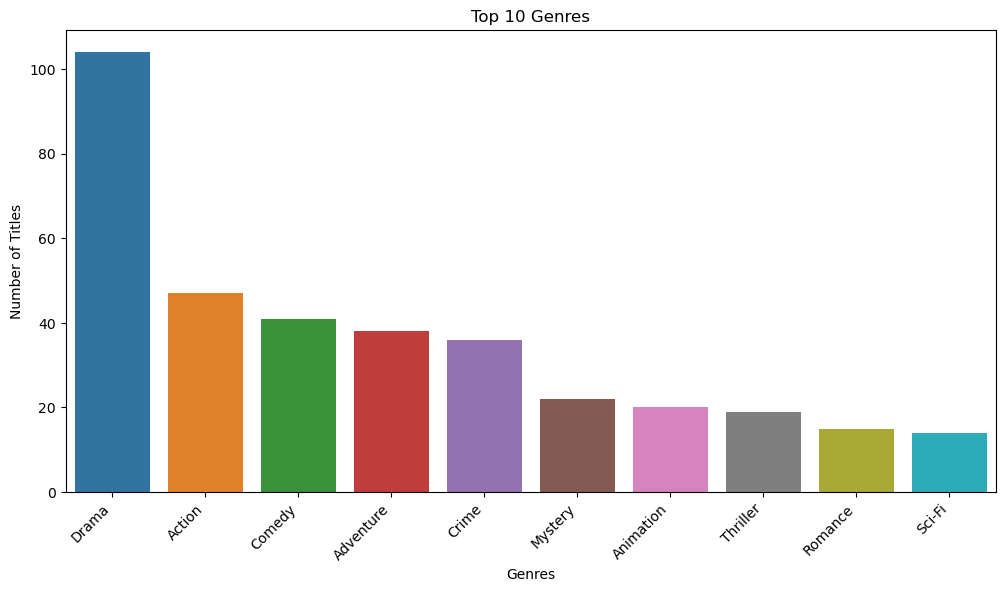

In [4]:
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=top_10_genres.index, y=top_10_genres['Count'])
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Top 10 Genres')
plt.ylabel('Number of Titles')
plt.xlabel('Genres')
plt.show()


## My ratings and IMDb Ratings Distribution

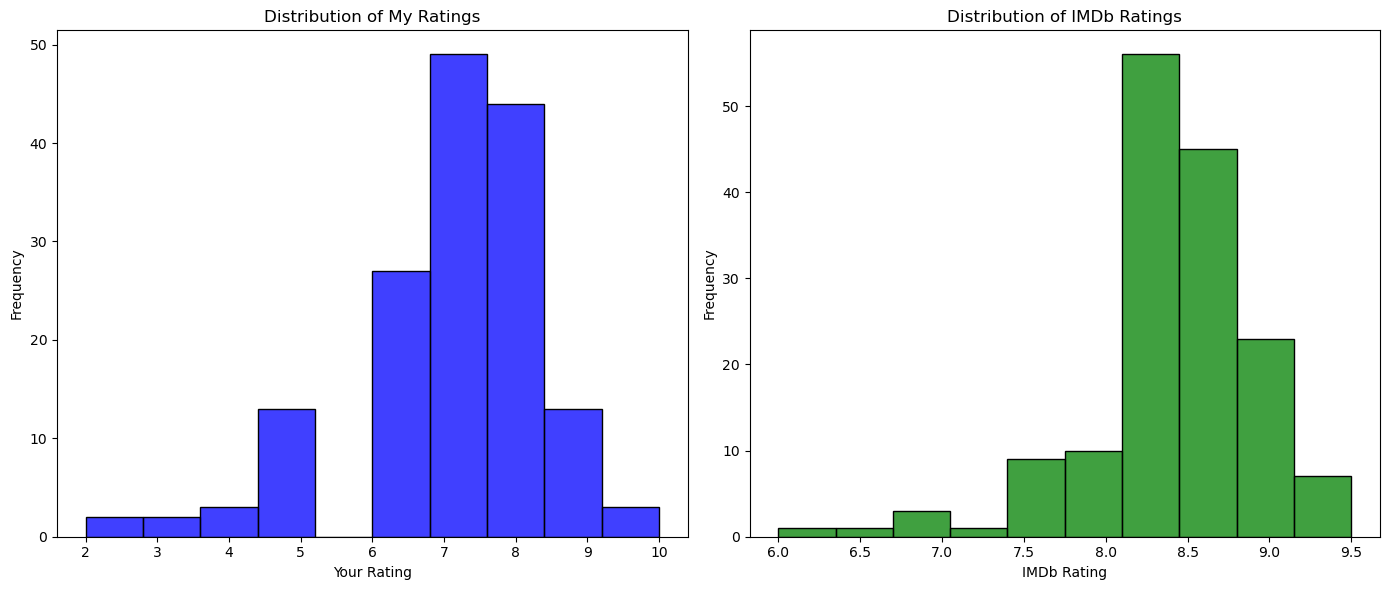

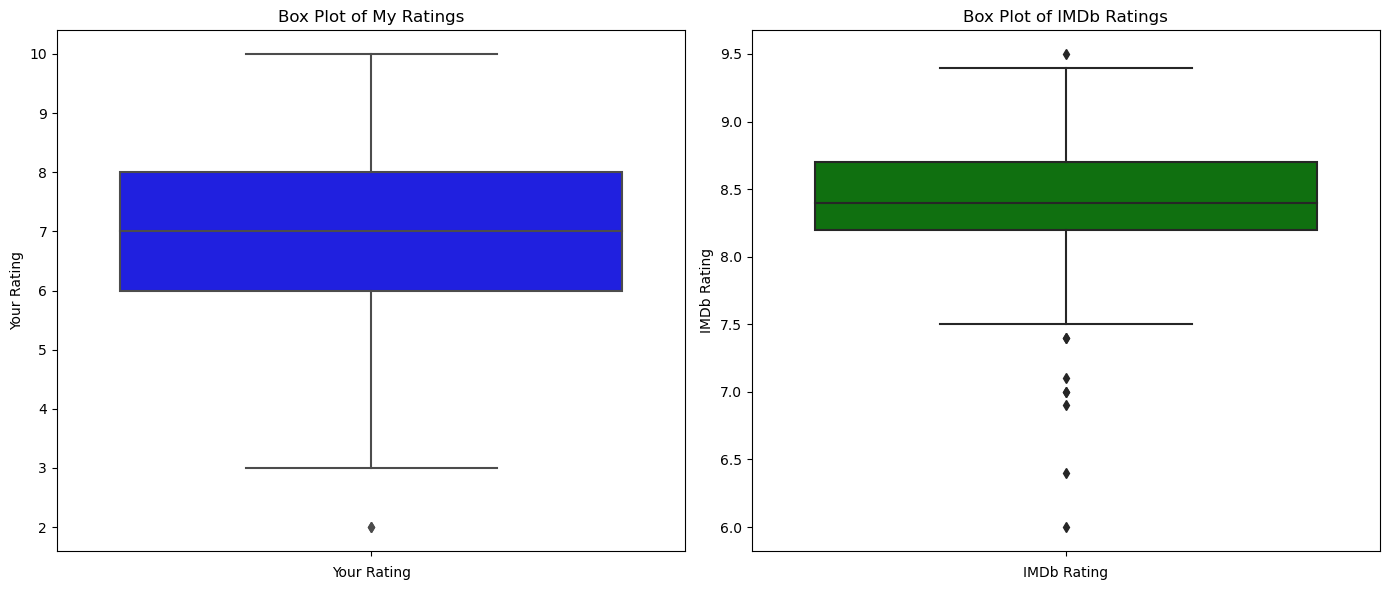

In [5]:
plt.figure(figsize=(14, 6))

# Histogram for user ratings
plt.subplot(1, 2, 1)
sns.histplot(df['Your Rating'], kde=False, bins=10, color='blue')
plt.title('Distribution of My Ratings')
plt.xlabel('Your Rating')
plt.ylabel('Frequency')

# Histogram for IMDb ratings
plt.subplot(1, 2, 2)
sns.histplot(df['IMDb Rating'], kde=False, bins=10, color='green')
plt.title('Distribution of IMDb Ratings')
plt.xlabel('IMDb Rating')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

# Box plot for user ratings
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Your Rating'], color='blue')
plt.title('Box Plot of My Ratings')
plt.xlabel('Your Rating')

# Box plot for IMDb ratings
plt.subplot(1, 2, 2)
sns.boxplot(y=df['IMDb Rating'], color='green')
plt.title('Box Plot of IMDb Ratings')
plt.xlabel('IMDb Rating')

plt.tight_layout()
plt.show()


## Director Analysis

In [23]:
df_directors = df['Directors'].str.split(', ').explode().reset_index()
df_directors = df_directors.join(df[['Your Rating', 'IMDb Rating', 'Title']], on='index')
df_directors.drop('index', axis=1, inplace=True)

df_directors['Your Rating'] = pd.to_numeric(df_directors['Your Rating'], errors='coerce')
df_directors['IMDb Rating'] = pd.to_numeric(df_directors['IMDb Rating'], errors='coerce')

director_your_rating = df_directors.groupby('Directors')['Your Rating'].mean()
director_imdb_rating = df_directors.groupby('Directors')['IMDb Rating'].mean()

director_movie_count = df_directors.groupby('Directors').size()

df_director_comparison = pd.DataFrame({
    'Your Average Rating': director_your_rating,
    'IMDb Average Rating': director_imdb_rating,
    'Number of Movies': director_movie_count
}).reset_index()

threshold = 3 
df_director_comparison[df_director_comparison['Number of Movies'] > threshold].sort_values('Your Average Rating', ascending=False).head(4)


,Directors,Your Average Rating,IMDb Average Rating,Number of Movies
9,Christopher Nolan,8.714286,8.571429,7
15,David Fincher,7.600000,8.180000,5
37,Martin Scorsese,7.200000,8.360000,5
47,Quentin Tarantino,7.200000,8.460000,5


## Stars Analysis

In [7]:
df_exploded_stars = df.assign(Stars=df['Stars'].str.split(', ')).explode('Stars')

avg_rating_by_star = df_exploded_stars.groupby('Stars')['Your Rating'].mean()

count_movies_by_star = df_exploded_stars.groupby('Stars').size()

df_star_ratings = pd.DataFrame({
    'Average Rating': avg_rating_by_star,
    'Number of Movies': count_movies_by_star
}).reset_index()

threshold = 3 
df_star_ratings_filtered = df_star_ratings[df_star_ratings['Number of Movies'] > threshold]


df_star_ratings_filtered.sort_values(by='Average Rating', ascending=False).head(10)



,Stars,Average Rating,Number of Movies
71,Christian Bale,8.500000,6
183,J.K. Simmons,8.250000,4
279,Kevin Spacey,8.250000,4
289,Leonardo DiCaprio,7.571429,7
125,Elijah Wood,7.500000,4
310,Mark Ruffalo,7.400000,5
408,Ryan Gosling,7.400000,5
50,Brad Pitt,7.200000,5
7,Al Pacino,7.000000,4
163,Harrison Ford,7.000000,4


## Correlation Matrix for Movies and Tv Shows

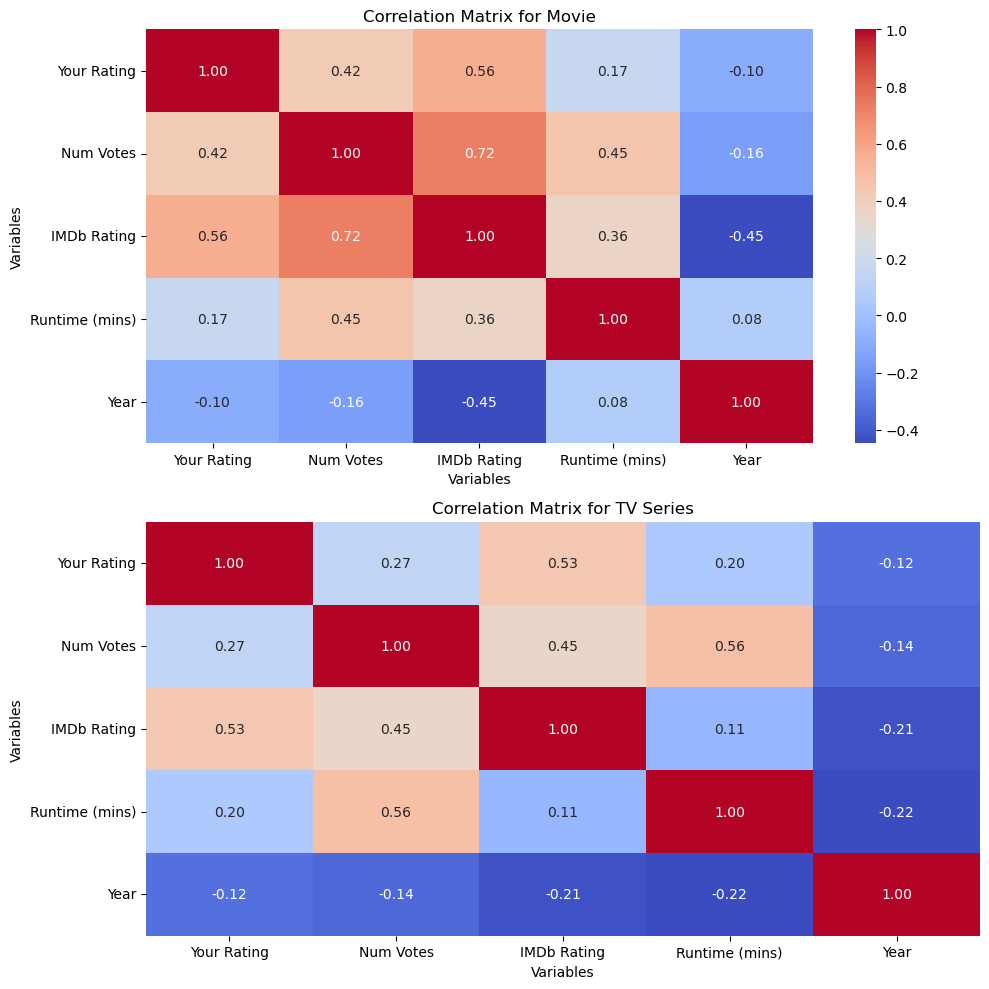

In [9]:


title_types = df['Title Type'].unique()

numeric_columns=["Your Rating","Num Votes","IMDb Rating",'Runtime (mins)', 'Year']
correlation_matrices = {}

for title_type in title_types:
    df_filtered = df[df['Title Type'] == title_type]

    df_numeric_filtered = df_filtered[numeric_columns]
    
    correlation_matrix = df_numeric_filtered.corr()

    correlation_matrices[title_type] = correlation_matrix

fig, axes = plt.subplots(len(title_types), 1, figsize=(10, 5 * len(title_types)))

for i, title_type in enumerate(title_types):
    sns.heatmap(correlation_matrices[title_type], annot=True, fmt=".2f", cmap='coolwarm', ax=axes[i], cbar=i == 0)
    axes[i].set_title(f'Correlation Matrix for {title_type}')
    axes[i].set_xlabel('Variables')
    axes[i].set_ylabel('Variables')

plt.tight_layout()
plt.show()


# Spotify

In [10]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

client_id = 'dc973dd99b9449ad94a2100aaa838ec7'
client_secret = '61d65f2e1daf43c298fcf7ee4e203776'
redirect_uri = 'http://localhost:8888/callback/'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri,
                                               scope="user-top-read user-read-recently-played"))


top_tracks = sp.current_user_top_tracks(limit=50, time_range='medium_term')


top_artists = sp.current_user_top_artists(limit=50, time_range='medium_term')

recent_tracks = sp.current_user_recently_played(limit=50)


In [11]:
artist_ids = [track['artists'][0]['id'] for track in top_tracks['items']]
artists = [sp.artist(artist_id) for artist_id in artist_ids]
genres = [artist['genres'] for artist in artists]

for i, track in enumerate(top_tracks['items']):
    track['genres'] = genres[i]

tracks_data = {'name': [], 'artist': [], 'album': [],"duration":[],"popularity":[],"genres":[]}
for track in top_tracks['items']:
    tracks_data['name'].append(track['name'])
    tracks_data['artist'].append(track['artists'][0]['name'])
    tracks_data['album'].append(track['album']['name'])
    tracks_data["duration"].append(track["duration_ms"])
    tracks_data["popularity"].append(track["popularity"])
    tracks_data["genres"].append(track["genres"])

df_tracks = pd.DataFrame(tracks_data)

## Genre Analysis

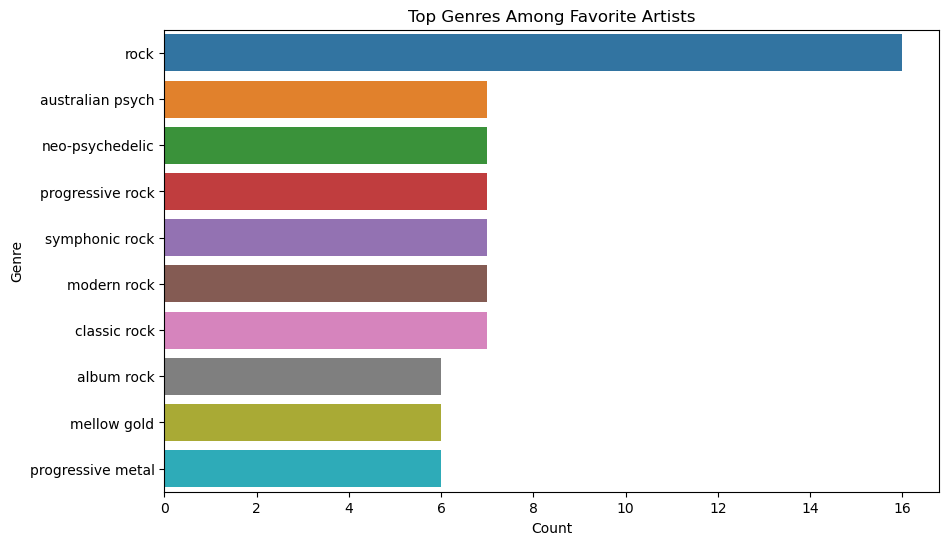

In [12]:
df_exploded_genres = df_tracks.explode('genres')

genre_counts = df_exploded_genres['genres'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Top Genres Among Favorite Artists')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

## Top Artists

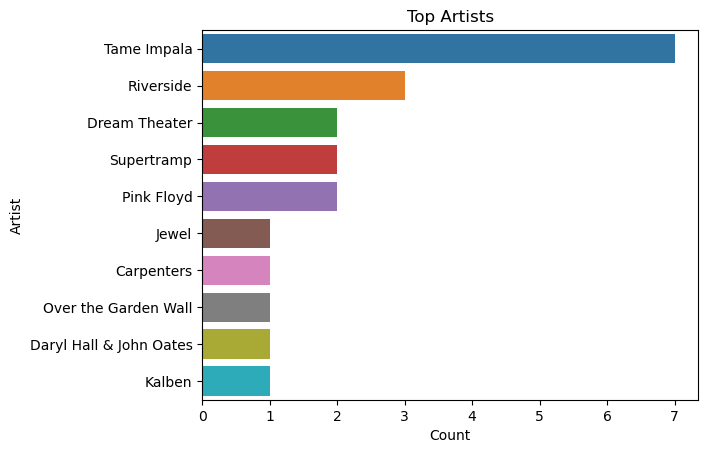

In [13]:
favorite_artist = df_tracks['artist'].mode()[0]
favorite_album = df_tracks['album'].mode()[0]

top_artists_count = df_tracks['artist'].value_counts().head(10)
sns.barplot(x=top_artists_count.values, y=top_artists_count.index)
plt.title('Top Artists')
plt.xlabel('Count')
plt.ylabel('Artist')
plt.show()


## Listening Habits by Hour of the Day

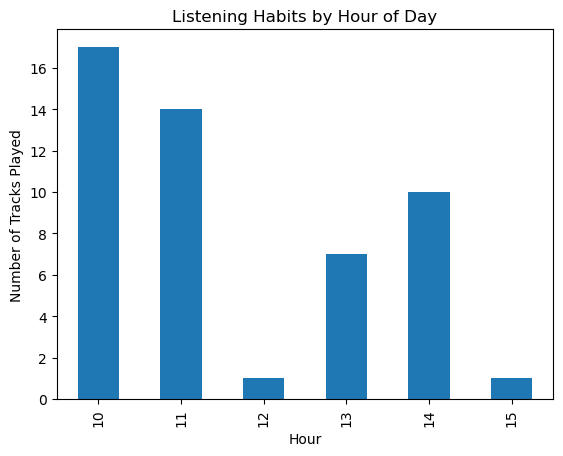

In [14]:
data = []
for track in recent_tracks['items']:
    played_at = track['played_at'] 
    track_name = track['track']['name']
    artist_name = track['track']['artists'][0]['name']
    data.append([played_at, track_name, artist_name])

df_recent = pd.DataFrame(data, columns=['played_at', 'track_name', 'artist_name'])

df_recent['played_at'] = pd.to_datetime(df_recent['played_at'])

df_recent['hour'] = df_recent['played_at'].dt.hour
hourly_listens = df_recent.groupby('hour').size()

hourly_listens.plot(kind='bar')
plt.title('Listening Habits by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Tracks Played')
plt.show()


## Comparison between IMDb data and Spotify data

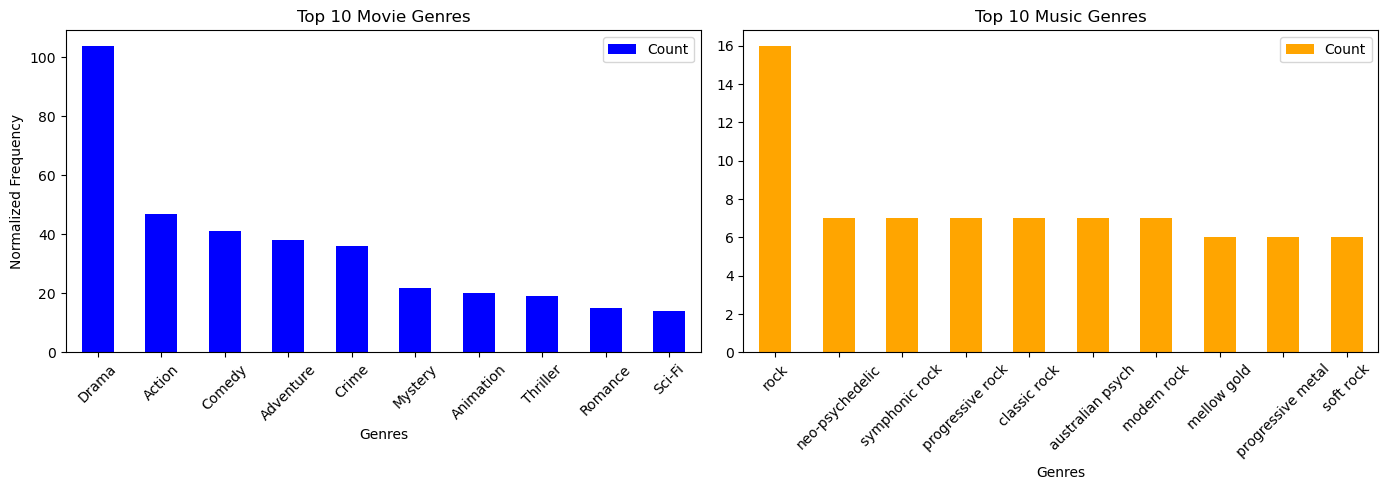

In [15]:
df_tracks_c = pd.DataFrame({
    'Count': df_tracks['name'].explode(),
    'Genres': df_tracks['genres'].explode(),
    
})

top_10_genres_music=df_tracks_c.groupby("Genres").count().sort_values(by="Count",ascending=False).head(10)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

top_10_genres.plot(kind='bar', ax=axes[0], color='blue')
axes[0].set_title('Top 10 Movie Genres')
axes[0].set_ylabel('Normalized Frequency')
axes[0].set_xlabel('Genres')
axes[0].tick_params(axis='x', rotation=45)

top_10_genres_music.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Top 10 Music Genres')
axes[1].set_xlabel('Genres')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [16]:
unique_music_genres = set(df_tracks.explode('genres')['genres'])
unique_movie_tv_genres = set(df.explode('Genres')['Genres'])
num_music_genres = len(unique_music_genres)
num_movie_tv_genres = len(unique_movie_tv_genres)

print("Number of unique music genres listened:", num_music_genres)
print("Number of unique movie/TV genres watched:", num_movie_tv_genres)


Number of unique music genres listened: 80
Number of unique movie/TV genres watched: 66


In [17]:
from scipy.stats import chi2_contingency

top_10_genres_music_list = top_10_genres_music.index.tolist()
top_10_genres_movie_list=top_10_genres.index.tolist()
data = {'Watched': top_10_genres_movie_list, 'Listened': top_10_genres_music_list}
a = pd.DataFrame(data)

contingency_table = pd.crosstab(a['Watched'], a['Listened'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"p-value: {p}")

p-value: 0.23134171389514135


# Machine Learning

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df.fillna({'Num Votes': df['Num Votes'].mean(), 'IMDb Rating': df['IMDb Rating'].mean()}, inplace=True)

features = ['Stars', 'Directors', 'Genres', 'Title Type', 'Num Votes', 'IMDb Rating']

categorical_cols = [cname for cname in features if df[cname].dtype == "object"]

for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')
    df[col] = df[col].astype(str)


numerical_cols = [cname for cname in features if df[cname].dtype in ['int64', 'float64']]

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = RandomForestRegressor(n_estimators=100, random_state=0)

y = df['Your Rating']
X = df.drop(['Your Rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['Num Votes', 'IMDb Rating']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Stars', 'Directors',
                                                   'Genres', 'Title Type'])])),
                ('model', RandomForestRegressor(random_state=0))])

In [19]:
preds = pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, preds)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 0.9587499999999999


## Predicting my Ratings of my Watchlist

In [20]:
login_url = "https://www.imdb.com/ap/signin?openid.pape.max_auth_age=0&openid.return_to=https%3A%2F%2Fwww.imdb.com%2Fregistration%2Fap-signin-handler%2Fimdb_us&openid.identity=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.assoc_handle=imdb_us&openid.mode=checkid_setup&siteState=eyJvcGVuaWQuYXNzb2NfaGFuZGxlIjoiaW1kYl91cyIsInJlZGlyZWN0VG8iOiJodHRwczovL3d3dy5pbWRiLmNvbS8_cmVmXz1sb2dpbiJ9&openid.claimed_id=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0%2Fidentifier_select&openid.ns=http%3A%2F%2Fspecs.openid.net%2Fauth%2F2.0&tag=imdbtag_reg-20"
watchlist_url = "https://www.imdb.com/user/ur77308892/watchlist?ref_=nv_usr_wl_all_0" 

driver = webdriver.Chrome()
driver.get(login_url)

time.sleep(3)

driver.find_element(By.ID, 'ap_email').send_keys(username)
driver.find_element(By.ID, 'ap_password').send_keys(password)
driver.find_element(By.ID, 'signInSubmit').click()

time.sleep(3)
driver.get(watchlist_url)

with open('watchlist.txt', 'w') as file:
    file.write(driver.page_source)

time.sleep(3)

driver.quit()

In [21]:
with open("watchlist.txt") as html_file:
    soup = BeautifulSoup(html_file, 'html.parser')

elements = soup.find_all('div', class_="lister-item featureFilm")

def parse_stars(element):
    credits = element.find('div', {'class': 'lister-item-credits'})
    stars=credits.find_all("a")[1:]
    star = [tag.get_text(strip=True) for tag in stars]
    stars_str = ', '.join(star)
    return stars_str

watchlist=pd.read_csv("WATCHLIST.csv")
watchlist=watchlist.drop(["Position","Const","Created", "Modified","Description","URL","Release Date","Your Rating","Date Rated"],axis=1)

watchlist["Stars"]=[parse_stars(i) for i in elements]
watchlist_predictions = pipeline.predict(watchlist)
watchlist['Predicted Rating'] = watchlist_predictions
watchlist[['Title', 'Predicted Rating']]

,Title,Predicted Rating
0,Citizen Kane,6.66
1,It's a Wonderful Life,7.57
2,Groundhog Day,5.93
3,Prisoners,5.89
4,L.A. Confidential,6.28
5,Drive,5.90
6,Trainspotting,5.62
7,Donnie Darko,5.92
8,The Bourne Ultimatum,6.19
9,The Wrestler,6.42
